In [7]:
import networkx as nx
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import sqlite3
from datetime import datetime as dt
import pandas as pd

%matplotlib inline

# Function definitions

In [8]:
def get_roads_from_XML(networkfile):
    import networkx as nx
    import numpy as np
    import xml.etree.ElementTree as ET
    # Read XML network
    #networkfile = '/home/frossi2/SVN/code/AMoD_congestion/AMoD_taxi/src/main/resources/NYOSMnetwork_25cap.xml'
    OSMNet=ET.parse(networkfile)
    root=OSMNet.getroot()
    nodes=root[0]
    links=root[1]
    G=nx.DiGraph()
    for node in nodes:
        #print node.tag, node.attrib
        #print int(node.get('id'))
        #Gr.add_node(int(node.get('id')))
        G.add_node(int(node.get('id')), x=float(node.get('x')), y=float(node.get('y')))
    LinkIDMap={}
    LinkIDReverseMap={}
    doubleEdgesNo=0
    for link in links:
        #print link.tag, link.attrib
        #if G.has_edge(int(link.get('from')),int(link.get('to'))):
        #    print 'Adding a second edge from '+ link.get('from') + ' to ' + link.get('to')
        #    doubleEdgesNo+=1
        G.add_edge(int(link.get('from')),int(link.get('to')), freespeed=float(link.get('freespeed')),
                    permlanes=float(link.get('permlanes')),capacity=float(link.get('capacity')),
                   length=float(link.get('length')),edgeid=int(link.get('id')))
        #if not G.has_edge(int(link.get('from')),int(link.get('to'))):
        #    print 'Something went wrong on link '+ link
        LinkIDMap[int(link.get('id'))]= [int(link.get('from')),int(link.get('to'))]
        LinkIDReverseMap[(int(link.get('from')),int(link.get('to')))] = int(link.get('id'))
    return G, LinkIDMap

def plot_roads(G):
    import networkx as nx
    import matplotlib.pyplot as plt
    nodepos={}
    for nodeix, node in G.node.iteritems():
        nodepos[nodeix]=[node['x'],node['y']]

    nx.draw_networkx_edges(G,nodepos)
    fig_size=[12,9]
        #fig_size[0] = 12
        #fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    plt.axis('equal')
    return 0
    
    
def get_XML_events_to_SQLite(eventsfile):
    import numpy as np
    import xml.etree.ElementTree as ET
    import sqlite3
    from datetime import datetime as dt
    import os.path
    import gzip
    
    if os.path.isfile(eventsfile[0:-4]+'.db'):
        print 'File'+eventsfile+': DB already exists'
        return
    # Read XML events
    print 'Reading events file: this may take a while'
    if os.path.isfile(eventsfile):
        EventsNet=ET.parse(eventsfile)
    else:
        with gzip.open(eventsfile+'.gz', 'rb') as eventsfilegz:
            EventsNet=ET.parse(eventsfilegz)
    

    eroot=EventsNet.getroot()
    print 'Creating SQLite database'
    conn = sqlite3.connect(eventsfile[0:-4]+'.db')
    c = conn.cursor()
    c.execute('''CREATE TABLE AMoDEvents
             (time float, actType text, link text, person text, vehicle text, type text)''')
    print 'Transferring XML to SQL DB'
    eventct=0
    for Event in eroot:
        eventct+=1
    #if Event.get('vehicle')=='amod_1':
    #    print Event.attrib
        c.execute("INSERT INTO AMoDEvents VALUES (?,?,?,?,?,?)",(float(Event.get('time')),Event.get('actType'),Event.get('link'),Event.get('person'),Event.get('vehicle'),Event.get('type')))
    print eventct
    conn.commit()
    conn.close()
    return 0

def get_XML_events_to_pandas(eventsfile):
    import numpy as np
    import xml.etree.ElementTree as ET
    import sqlite3
    from datetime import datetime as dt
    import os.path
    import gzip
    import pandas as pd
    
    # Read XML events
    print 'Reading events file: this may take a while'
    if os.path.isfile(eventsfile):
        EventsNet=ET.parse(eventsfile)
    else:
        with gzip.open(eventsfile+'.gz', 'rb') as eventsfilegz:
            EventsNet=ET.parse(eventsfilegz)
    

    eroot=EventsNet.getroot()
    eventct=0
    records=[]
    for Event in eroot:
        eventct+=1
        records.append([float(Event.get('time')),Event.get('actType'),Event.get('link'),Event.get('person'),Event.get('vehicle'),Event.get('type')])
    print eventct
    df=pd.DataFrame(records,columns=('time','actType','link','person', 'vehicle', 'type'))
    
    return df

def get_traffic_data(eventsfile,LinkIDMap):
    # Traffic: number of vehicles on each link per hour
    import sqlite3
    conn = sqlite3.connect(eventsfile[0:-4]+'.db')
    c = conn.cursor()
    
    VehiclesPerHr=np.zeros([len(G.edges()),24])
    RelUtilPerHr =np.zeros([len(G.edges()),24])
    for h in range(24):
        print h
        tmin=3600*h
        tmax=tmin+3600
        t=('entered link',tmin,tmax)
        c.execute('SELECT * FROM AMoDEvents WHERE type=? AND time>? AND time<?',t)
        linksevents=c.fetchall()
        linksId=np.array(map(lambda x: int(x[2]), linksevents))
        for linkId in linksId:
            VehiclesPerHr[linkId-1][h]+=1.
            RelUtilPerHr[linkId-1][h]+=1.
        for link in LinkIDMap.keys():
            RelUtilPerHr[link-1][h]=RelUtilPerHr[link-1][h]/float(G.edge[LinkIDMap[link][0]][LinkIDMap[link][1]]['capacity'])
        #for link in LinkIDMap.keys():
            #if not link % 100:
        #    print link
        #    VehiclesPerHr[link-1][h]=reduce(lambda x, y: x+1 if y==link else x, linksId,0)
            #VehiclesPerHr[link-1][h]=sum(linksId==link)
    conn.close()
    return VehiclesPerHr, RelUtilPerHr

def plot_traffic_data(G,RelUtilPerHr,LinkIDMap,hours):
    import networkx as nx
    import matplotlib.pyplot as plt
    import sqlite3
    
    myedgelist=[]
    for i in range(len(LinkIDMap.keys())):
        myedgelist.append(LinkIDMap[i+1])
    nodepos={}
    for nodeix, node in G.node.iteritems():
        nodepos[nodeix]=[node['x'],node['y']]

    for h in hours:
        plt.figure()
        plt.subplot(121)
        traffic=nx.draw_networkx_edges(G,nodepos,edgelist=myedgelist,edge_color=RelUtilPerHr[...,h],edge_cmap=plt.cm.Blues,node_size=0,arrows=False,vmin=0,vmax=1)
        fig_size=[12,9]
        #fig_size[0] = 12
        #fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size
        #nx.draw(G,nodepos,node_size=1)
        traffic.set_clim(0,1)
        plt.colorbar(traffic)
        plt.axis('equal')
        plt.title(str(h)+' to '+str(h+1))
    return 0



In [9]:
def plot_vehicle_history(G,eventsfile,LinkIDMap,vehiclenumber):
    import networkx as nx
    import matplotlib.pyplot as plt
    import sqlite3
    import os.path
    
    #Let's make a function to plot individual vehicles
    conn = sqlite3.connect(eventsfile[0:-4]+'.db')
    c = conn.cursor()

    #t=('amod_2','entered link')
    #c.execute('SELECT * FROM AMoDEvents WHERE vehicle=? AND type=?',t)
    #vehicleroute=c.fetchall()

    #t=('amod_1','PersonEntersVehicle','PersonLeavesVehicle')
    #c.execute('SELECT * FROM AMoDEvents WHERE vehicle=? AND (type=? OR TYPE=?)',t)
    #vehiclepax=c.fetchall()
    vehicleID= 'amod_'+str(vehiclenumber)
    t=(vehicleID,'entered link','PersonEntersVehicle','PersonLeavesVehicle')
    c.execute('SELECT * FROM AMoDEvents WHERE vehicle=? AND (type=? OR type=? OR type=?)',t)
    vehiclestory=c.fetchall()
    conn.close()
    
    myedgelist=[]
    for i in range(len(LinkIDMap.keys())):
        myedgelist.append(LinkIDMap[i+1])
    nodepos={}
    for nodeix, node in G.node.iteritems():
        nodepos[nodeix]=[node['x'],node['y']]
    
    Linkstory=np.zeros([len(G.edges())])
    vehcolor=1
    for ev in vehiclestory:
        if ev[5]=='PersonEntersVehicle':
            vehcolor=2
        if ev[5]=='PersonLeavesVehicle':
            vehcolor=1
        if ev[5]=='entered link':
            Linkstory[int(ev[2])]=max(Linkstory[int(ev[2])-1],vehcolor)
            #Linkstory[int(ev[2])]=Linkstory[int(ev[2])]+vehcolor

    plt.figure()
    plt.subplot(121)
    traffic=nx.draw_networkx_edges(G,nodepos,edgelist=myedgelist,edge_color=Linkstory,edge_cmap=plt.cm.Blues,node_size=0,arrows=False)
    fig_size=[12,9]
    #fig_size[0] = 12
    #fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    #nx.draw(G,nodepos,node_size=1)
    #traffic.set_clim(0,1)
    #plt.colorbar(traffic)
    plt.axis('equal')
    return 0

def plot_pax_route(G,eventsfile,LinkIDMap,paxnumber):
    #Let's make a function to plot individual pax
    import networkx as nx
    import matplotlib.pyplot as plt
    import sqlite3
    
    conn = sqlite3.connect(eventsfile[0:-4]+'.db')
    c = conn.cursor()

    t=(str(paxnumber),'entered link','PersonEntersVehicle','PersonLeavesVehicle')
    c.execute('SELECT * FROM AMoDEvents WHERE person=? AND (type=? OR type=? OR type=?)',t)
    paxstory=c.fetchall()

    t=(paxstory[0][4],'entered link',paxstory[0][0]-1.,paxstory[1][0]+1.)
    c.execute('SELECT * FROM AMoDEvents WHERE vehicle=? AND type=? AND time>=? AND time<=?',t)
    paxroute=c.fetchall()
    conn.close()
    
    Linkpaxstory=np.zeros([len(G.edges())])

    myedgelist=[]
    for i in range(len(LinkIDMap.keys())):
        myedgelist.append(LinkIDMap[i+1])
    nodepos={}
    for nodeix, node in G.node.iteritems():
        nodepos[nodeix]=[node['x'],node['y']]
        
    for ev in paxroute:
            Linkpaxstory[int(ev[2])-1]=1
            #Linkstory[int(ev[2])]=Linkstory[int(ev[2])]+vehcolor

    plt.figure()
    plt.subplot(121)
    traffic=nx.draw_networkx_edges(G,nodepos,edgelist=myedgelist,edge_color=Linkpaxstory,edge_cmap=plt.cm.Blues,node_size=0,arrows=False)
    fig_size=[12,9]
    #fig_size[0] = 12
    #fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    #nx.draw(G,nodepos,node_size=1)
    #traffic.set_clim(0,1)
    #plt.colorbar(traffic)
    plt.axis('equal')

In [10]:
def extract_pax_statistics(eventsfile,plansfile):
    # Let us now extract individual departure and arrival times. We will also extract request times from Plans
    #  and compute per-hour statistics
    import sqlite3
    import pickle
    import os.path
    import datetime as dt
    
    times=[dt.datetime(2012,3,1,0,0,0)]
    for i in range(1,24*60):
        times.append(times[0]+dt.timedelta(minutes=i))
    
    
    waitfilename='WaitTime_'+eventsfile.split('/')[-4]
    servfilename='ServTime_'+eventsfile.split('/')[-4]
    datafilename='PaxData_'+eventsfile.split('/')[-4]
    if (os.path.isfile(waitfilename) and os.path.isfile(servfilename) and os.path.isfile(datafilename)):
        print 'File already exists, loading from cache'
        out_wait=open(waitfilename,'rb')
        out_serv=open(servfilename,'rb')
        out_data=open(datafilename,'rb')
        MeanWaitTime=pickle.load(out_wait)
        MeanServiceTime=pickle.load(out_serv)
        paxdata=pickle.load(out_data)
        out_wait.close()
        out_serv.close()
        out_data.close()
    else:
        print 'Computing pax statistics, this will be a while...'
        conn = sqlite3.connect(eventsfile[0:-4]+'.db')
        c = conn.cursor()

        # Read XML events
        #plansfile = '/home/frossi2/SVN/code/AMoD_congestion/AMoD_taxi/src/main/resources/plans/march05plansOSM_24h.xml'
        PlansNet=ET.parse(plansfile)
        proot=PlansNet.getroot()
        deptime_zero=dt.strptime('00:00:00','%H:%M:%S')

        pnum=0
        pids=[]
        pstarts=[]
        paxdata={}
        for person in proot:
            pid=person.get('id')
            pids.append(int(pid))
            plan=person.getchildren()[0]
            #print plan.getchildren()
            leg=plan.find('leg')
            #print leg.attrib
            deptime=leg.get('dep_time')
            #print deptime, type(deptime)
            deptime_dt=dt.strptime(deptime,'%H:%M:%S')
            deptime_seconds=(deptime_dt-deptime_zero).total_seconds() 
            pstarts.append(deptime_seconds)
            pnum+=1
            paxdata[int(pid)]=[deptime_seconds, 0., 0.]

        t=('PersonEntersVehicle','PersonLeavesVehicle')
        c.execute('SELECT * FROM AMoDEvents WHERE (type=? OR type=?)',t)
        paxdeparr=c.fetchall()

        #paxdeparr[0]:time. paxdeparr[3]:passengerID. paxdeparr[5]:type (enters or exits)
        paxid=0
        for pax in paxdeparr:
            paxid+=1
            if len(pax[3])>5 and pax[3][0:5]=='amod_':
                continue
            #print pax
            if pax[5]==u'PersonEntersVehicle':
                paxdata[int(pax[3])][1]=float(pax[0])
            elif pax[5]=='PersonLeavesVehicle':
                paxdata[int(pax[3])][2]=float(pax[0])
            else:
                print 'Error: unrecognized string'
                print pax
                break

    def paxwaittime(x):
        return x[1]-x[0]
    def paxservtime(x):
        return x[2]-x[0]

    paxWaitTimes=np.array(map(paxwaittime,paxdata.values()))
    paxServiceTimes=np.array(map(paxservtime,paxdata.values()))
    paxdatavals=np.array(paxdata.values())
    MeanWaitTime=np.zeros([24])
    MeanServiceTime=np.zeros([24])

    for t in range(24):
        MeanWaitTime[t]=np.mean(paxWaitTimes[np.logical_and(paxdatavals[...,0]<3600*(t+1),paxdatavals[...,0]>=3600*t)])
        MeanServiceTime[t]=np.mean(paxServiceTimes[np.logical_and(paxdatavals[...,0]<3600*(t+1),paxdatavals[...,0]>=3600*t)])
    
    deltat=dt.timedelta(seconds=15.*60.)
    SlidingWaitTime=np.zeros(len(times))
    SlidingServTime=np.zeros(len(times))
    for i in range(len(times)):
        window_high=((times[i]+deltat)-times[0]).total_seconds()
        window_low =((times[i]-deltat)-times[0]).total_seconds()
        SlidingWaitTime[i]=np.mean(paxWaitTimes[np.logical_and(paxdatavals[...,0]<window_high,paxdatavals[...,0]>=window_low)])
        SlidingServTime[i]=np.mean(paxServiceTimes[np.logical_and(paxdatavals[...,0]<window_high,paxdatavals[...,0]>=window_low)])

    
    out_wait=open(waitfilename,'wb')
    out_serv=open(servfilename,'wb')
    out_data=open(datafilename,'wb')
    pickle.dump(MeanWaitTime,out_wait)
    pickle.dump(MeanServiceTime,out_serv)
    pickle.dump(paxdata,out_data)
    out_wait.close()
    out_serv.close()
    out_data.close()
    
    return MeanWaitTime, MeanServiceTime, times, SlidingWaitTime, SlidingServTime

# Read network

0

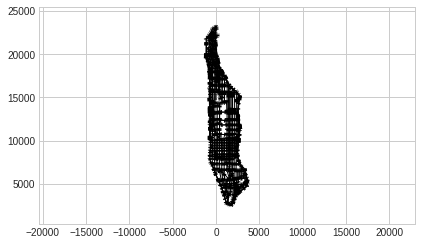

In [11]:
networkfile = '/home/frossi2/SVN/code/AMoD_congestion/AMoD_taxi/src/main/resources/NYOSMnetwork_25cap.xml'

import matplotlib.pyplot as plt

G, LinkIDMap =get_roads_from_XML(networkfile)

plot_roads(G)

# Read events

In [32]:
# basefolder = '/home/frossi2/SVN/code/AMoD_congestion/AMoD_taxi/test/output/'
basefolder = '/media/Big_Data/frossi2/test/output/'

eventsfile_C = basefolder+'01x05_pax-reb_congestion_OSM_24h_25cap_trial20170203_1356_matlabcap120x_reb120_30_randomreb/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_C)
eventsfile_L = basefolder+'01x05_pax-reb_legacy_OSM_24h_25cap_trial20170201_1118_matlabcap120x_reb120_15/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_L)
eventsfile_N = basefolder+'01x05_no-reb_OSM_24h_25cap_trial20170206_1518/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_N)

eventsfile_C_30 = basefolder+'01x05_pax-reb_congestion_OSM_24h_30cap_trial20170203_1921_matlabcap120x_reb120_randomreb/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_C_30)
eventsfile_L_30 = basefolder+'01x05_pax-reb_legacy_OSM_24h_30cap_trial20170203_1921_matlabcap120x_reb120/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_L_30)
eventsfile_N_30 = basefolder+'01x05_no-reb_OSM_24h_30cap_trial20170206_1703/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_N_30)

eventsfile_C_20 = basefolder+'01x05_pax-reb-congestion_OSM_24h_20cap_trial20170207_1340_matlabcap120x_reb120_30_randomreb/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_C_20)
eventsfile_L_20 = basefolder+'01x05_pax-reb-legacy_OSM_24h_20cap_trial20170207_1340_matlabcap120x_reb120_30_randomreb/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_L_20)
eventsfile_N_20 = basefolder+'01x05_pax-noreb_OSM_24h_20cap_trial20170207_1340/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_N_20)

eventsfile_C_27 = basefolder+'01x05_pax-reb_congestion_OSM_24h_27cap_trial20170208_1015_matlabcap120x_reb120_30_randomreb/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_C_27)
eventsfile_L_27 = basefolder+'01x05_pax-reb_legacy_OSM_24h_27cap_trial20170208_1015_matlabcap120x_reb120_30_randomreb/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_L_27)
eventsfile_N_27 = basefolder+'01x05_no-reb_OSM_24h_27cap_trial20170210_0011/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_N_27)

eventsfile_C_22 = basefolder+'01x05_pax-reb_congestion_OSM_24h_22p5cap_trial20170210_1547_matlabcap120x_reb120_15_randomdepartures/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_C_22)
eventsfile_L_22 = basefolder+'01x05_pax-reb_legacy_OSM_24h_22p5cap_trial20170210_1547_matlabcap120x_reb120_15_randomdepartures/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_L_22)
eventsfile_N_22 = basefolder+'01x05_no-reb_OSM_24h_22p5cap_trial20170210_1513/ITERS/it.0/0.events.xml'
get_XML_events_to_SQLite(eventsfile_N_22)




File/media/Big_Data/frossi2/test/output/01x05_pax-reb_congestion_OSM_24h_25cap_trial20170203_1356_matlabcap120x_reb120_30_randomreb/ITERS/it.0/0.events.xml: DB already exists
File/media/Big_Data/frossi2/test/output/01x05_pax-reb_legacy_OSM_24h_25cap_trial20170201_1118_matlabcap120x_reb120_15/ITERS/it.0/0.events.xml: DB already exists
File/media/Big_Data/frossi2/test/output/01x05_no-reb_OSM_24h_25cap_trial20170206_1518/ITERS/it.0/0.events.xml: DB already exists
File/media/Big_Data/frossi2/test/output/01x05_pax-reb_congestion_OSM_24h_30cap_trial20170203_1921_matlabcap120x_reb120_randomreb/ITERS/it.0/0.events.xml: DB already exists
File/media/Big_Data/frossi2/test/output/01x05_pax-reb_legacy_OSM_24h_30cap_trial20170203_1921_matlabcap120x_reb120/ITERS/it.0/0.events.xml: DB already exists
File/media/Big_Data/frossi2/test/output/01x05_no-reb_OSM_24h_30cap_trial20170206_1703/ITERS/it.0/0.events.xml: DB already exists
File/media/Big_Data/frossi2/test/output/01x05_pax-reb-congestion_OSM_24h_20c

In [15]:
eventsfile_C = '01x05_pax-reb_congestion_OSM_24h_25cap_trial20170203_1356_matlabcap120x_reb120_30_randomreb/ITERS/it.0/0.events.xml'

df_C_25=get_XML_events_to_pandas(eventsfile_C)

Reading events file: this may take a while


KeyboardInterrupt: 

In [7]:
VehiclesPerHr_C, RelUtilPerHr_C = get_traffic_data(eventsfile_C,LinkIDMap)
np.save('VehiclesPerHr_congestion','VehiclesPerHr')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


0

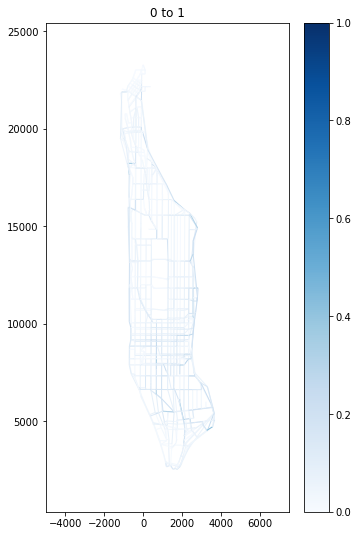

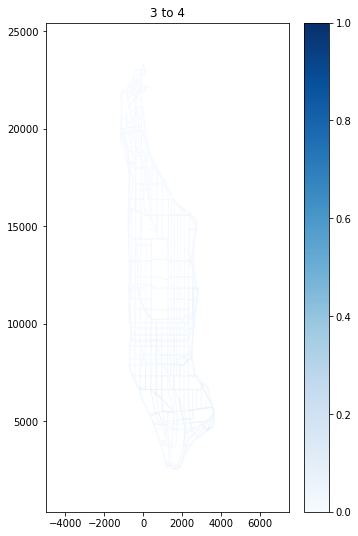

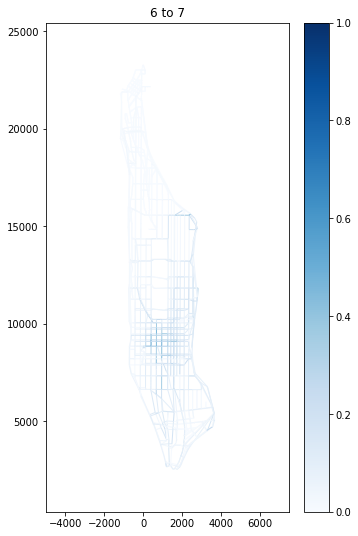

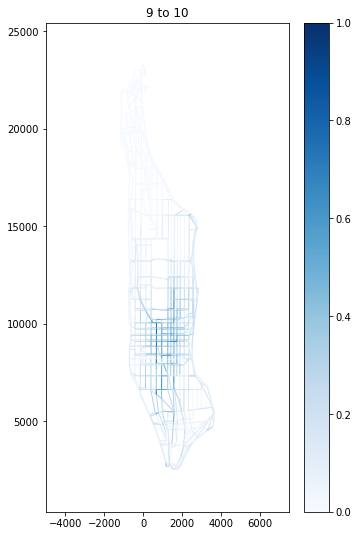

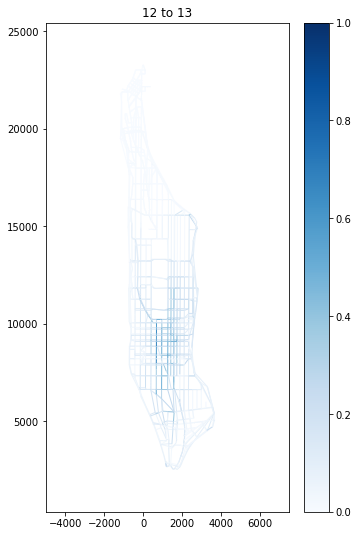

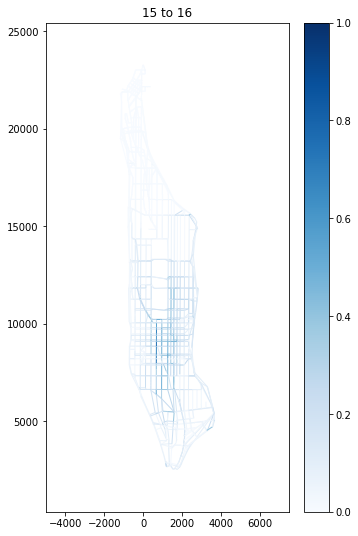

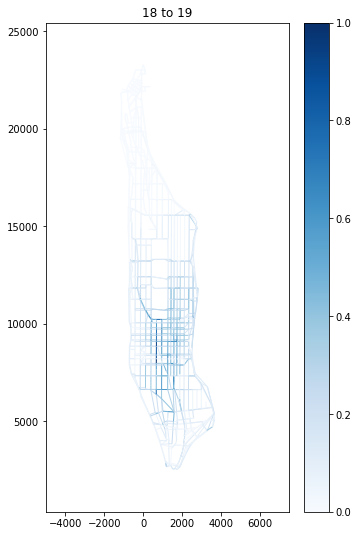

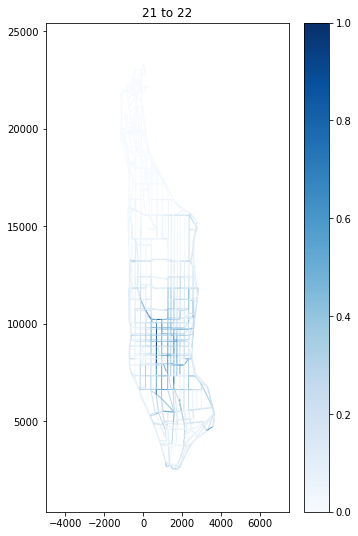

In [8]:
hours=range(0,24,3)
plot_traffic_data(G,RelUtilPerHr_C,LinkIDMap,hours)

0

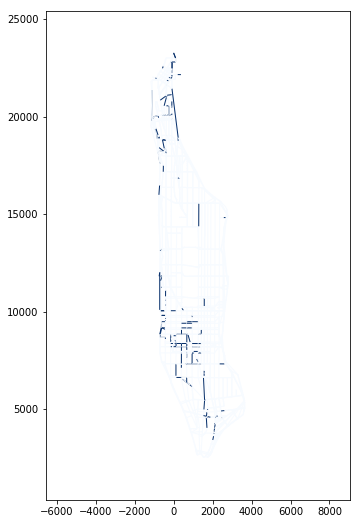

In [11]:
vehiclenumber=6000
plot_vehicle_history(G,eventsfile_C,LinkIDMap,vehiclenumber)

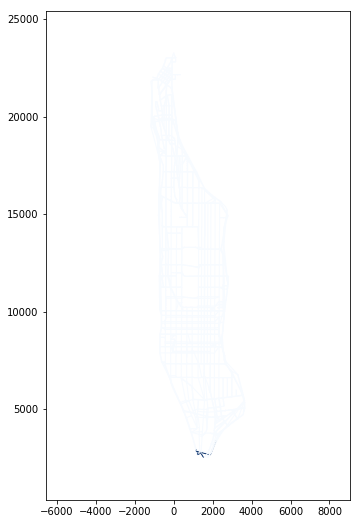

In [14]:
paxnumber=4500
plot_pax_route(G,eventsfile_C,LinkIDMap,paxnumber)

In [16]:
plansfile = '/home/frossi2/SVN/code/AMoD_congestion/AMoD_taxi/src/main/resources/plans/march05plansOSM_24h.xml'

selector=25

widerange=0


MeanWaitTime_C_25, MeanServiceTime_C_25, times_C_25, SlidingWaitTime_C_25, SlidingServTime_C_25=extract_pax_statistics(eventsfile_C,plansfile)
MeanWaitTime_L_25, MeanServiceTime_L_25, times_L_25, SlidingWaitTime_L_25, SlidingServTime_L_25=extract_pax_statistics(eventsfile_L,plansfile)
MeanWaitTime_N_25, MeanServiceTime_N_25, times_N_25, SlidingWaitTime_N_25, SlidingServTime_N_25=extract_pax_statistics(eventsfile_N,plansfile)


MeanWaitTime_C_30, MeanServiceTime_C_30, times_C_30, SlidingWaitTime_C_30, SlidingServTime_C_30=extract_pax_statistics(eventsfile_C_30,plansfile)
MeanWaitTime_L_30, MeanServiceTime_L_30, times_L_30, SlidingWaitTime_L_30, SlidingServTime_L_30=extract_pax_statistics(eventsfile_L_30,plansfile)
MeanWaitTime_N_30, MeanServiceTime_N_30, times_N_30, SlidingWaitTime_N_30, SlidingServTime_N_30=extract_pax_statistics(eventsfile_N_30,plansfile)

MeanWaitTime_C_20, MeanServiceTime_C_20, times_C_20, SlidingWaitTime_C_20, SlidingServTime_C_20=extract_pax_statistics(eventsfile_C_20,plansfile)
MeanWaitTime_L_20, MeanServiceTime_L_20, times_L_20, SlidingWaitTime_L_20, SlidingServTime_L_20=extract_pax_statistics(eventsfile_L_20,plansfile)
MeanWaitTime_N_20, MeanServiceTime_N_20, times_N_20, SlidingWaitTime_N_20, SlidingServTime_N_20=extract_pax_statistics(eventsfile_N_20,plansfile)
    
if widerange:
    MeanWaitTime_C_27, MeanServiceTime_C_27, times_C_27, SlidingWaitTime_C_27, SlidingServTime_C_27=extract_pax_statistics(eventsfile_C_27,plansfile)
    MeanWaitTime_L_27, MeanServiceTime_L_27, times_L_27, SlidingWaitTime_L_27, SlidingServTime_L_27=extract_pax_statistics(eventsfile_L_27,plansfile)
    MeanWaitTime_N_27, MeanServiceTime_N_27, times_N_27, SlidingWaitTime_N_27, SlidingServTime_N_27=extract_pax_statistics(eventsfile_N_27,plansfile)
    
    MeanWaitTime_C_22, MeanServiceTime_C_22, times_C_22, SlidingWaitTime_C_22, SlidingServTime_C_22=extract_pax_statistics(eventsfile_C_22,plansfile)
    MeanWaitTime_L_22, MeanServiceTime_L_22, times_L_22, SlidingWaitTime_L_22, SlidingServTime_L_22=extract_pax_statistics(eventsfile_L_22,plansfile)
    MeanWaitTime_N_22, MeanServiceTime_N_22, times_N_22, SlidingWaitTime_N_22, SlidingServTime_N_22=extract_pax_statistics(eventsfile_N_22,plansfile)

File already exists, loading from cache
File already exists, loading from cache
File already exists, loading from cache
File already exists, loading from cache
File already exists, loading from cache
File already exists, loading from cache
File already exists, loading from cache
File already exists, loading from cache
File already exists, loading from cache


[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-bright', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


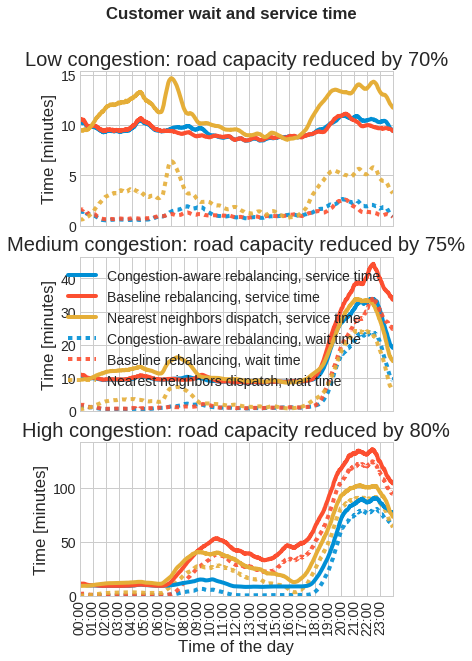

In [20]:
#plt.figure()
#plt.plot(MeanWaitTime_C,label='Congestion-aware')
#plt.plot(MeanWaitTime_L,label='Legacy')
#plt.plot(MeanWaitTime_N,label='K-nearest neighbors')
#plt.legend()
print(plt.style.available)
plt.style.use(['fivethirtyeight','seaborn-white','seaborn-whitegrid'])
import matplotlib.dates as mdates

fig=plt.figure(figsize=(5,9))
st=fig.suptitle("Customer wait and service time",fontsize='large',fontweight='bold')
ax1 =plt.subplot(311)
hfmt = mdates.DateFormatter('%H:00')
ax1.plot(times_C_30,SlidingWaitTime_C_30/60.,color='C0',linestyle='dotted',alpha=0.9,label='Wait time, congestion-aware rebalancing')
ax1.plot(times_L_30,SlidingWaitTime_L_30/60.,color='C1',linestyle='dotted',alpha=0.9,label='Wait time, legacy rebalancing')
ax1.plot(times_N_30,SlidingWaitTime_N_30/60.,color='C2',linestyle='dotted',alpha=0.9,label='Wait time, K-nearest neighbors dispatch')
ax1.plot(times_C_30,SlidingServTime_C_30/60.,color='C0',label='Service time, congestion-aware rebalancing')
ax1.plot(times_L_30,SlidingServTime_L_30/60.,color='C1',label='Service time, legacy rebalancing')
ax1.plot(times_N_30,SlidingServTime_N_30/60.,color='C2',label='Service time, K-nearest neighbors dispatch')
#ax1.xaxis.set_major_locator(mdates.HourLocator())
#ax1.xaxis.set_major_formatter(hfmt)
plt.setp(ax1.get_xticklabels(),visible=False)
ax1.set_xlim(min(times_C_30),max(times_C_30))
ax1.set_ylim(bottom = 0)
#ax1.set_xlabel('Time of the day')
ax1.set_ylabel('Time [minutes]')
ax1.set_title('Low congestion: road capacity reduced by 70%')
plt.xticks(rotation='vertical')
#ax1.legend()

ax2 =plt.subplot(312,sharex=ax1)
hfmt = mdates.DateFormatter('%H:00')
ax2.plot(times_C_25,SlidingServTime_C_25/60.,color='C0',label='Congestion-aware rebalancing, service time')
ax2.plot(times_L_25,SlidingServTime_L_25/60.,color='C1',label='Baseline rebalancing, service time')
ax2.plot(times_N_25,SlidingServTime_N_25/60.,color='C2',label='Nearest neighbors dispatch, service time')
ax2.plot(times_C_25,SlidingWaitTime_C_25/60.,color='C0',linestyle='dotted',alpha=0.9,label='Congestion-aware rebalancing, wait time')
ax2.plot(times_L_25,SlidingWaitTime_L_25/60.,color='C1',linestyle='dotted',alpha=0.9,label='Baseline rebalancing, wait time')
ax2.plot(times_N_25,SlidingWaitTime_N_25/60.,color='C2',linestyle='dotted',alpha=0.9,label='Nearest neighbors dispatch, wait time')
#ax2.xaxis.set_major_locator(mdates.HourLocator())
#ax2.xaxis.set_major_formatter(hfmt)
ax2.set_xlim(min(times_C_25),max(times_C_25))
ax2.set_ylim(bottom = 0)

plt.setp(ax2.get_xticklabels(),visible=False)
#ax2.set_xlabel('Time of the day')
ax2.set_ylabel('Time [minutes]')
ax2.set_title('Medium congestion: road capacity reduced by 75%')
plt.xticks(rotation='vertical')
mylegend=ax2.legend(loc=0,shadow=True)
mylegend.get_frame().set_facecolor('w')
#ax2.set_axis_bgcolor('w')

ax3 =plt.subplot(313,sharex=ax1)
hfmt = mdates.DateFormatter('%H:00')
ax3.plot(times_C_20,SlidingWaitTime_C_20/60.,color='C0',linestyle='dotted',alpha=0.9)
ax3.plot(times_L_20,SlidingWaitTime_L_20/60.,color='C1',linestyle='dotted',alpha=0.9)
ax3.plot(times_N_20,SlidingWaitTime_N_20/60.,color='C2',linestyle='dotted',alpha=0.9)
ax3.plot(times_C_20,SlidingServTime_C_20/60.,color='C0')
ax3.plot(times_L_20,SlidingServTime_L_20/60.,color='C1')
ax3.plot(times_N_20,SlidingServTime_N_20/60.,color='C2')
ax3.xaxis.set_major_locator(mdates.HourLocator())
ax3.xaxis.set_major_formatter(hfmt)
ax3.set_xlim(min(times_C_20),max(times_C_20))
ax3.set_ylim(bottom = 0)
ax3.set_xlabel('Time of the day')
ax3.set_ylabel('Time [minutes]')
ax3.set_title('High congestion: road capacity reduced by 80%')
plt.xticks(rotation='vertical')

fig.patch.set_facecolor([1, 1, 1, 1])
#plt.show()
plt.savefig('MATSIM_result_plot.pdf',bbox_inches='tight',facecolor='w')

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-bright', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


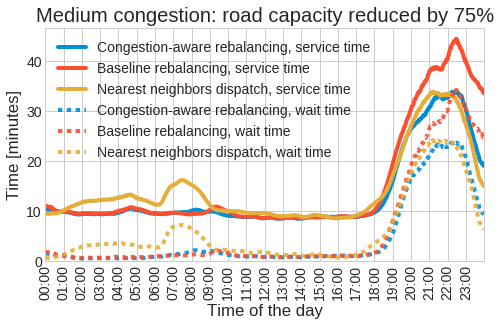

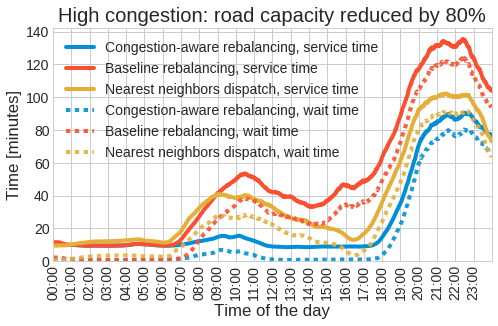

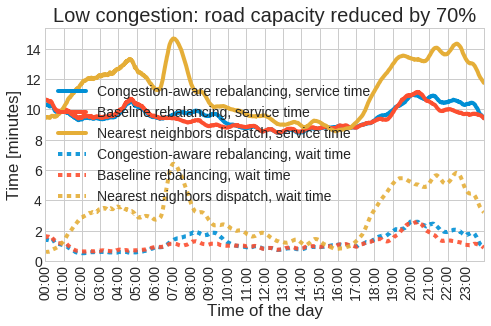

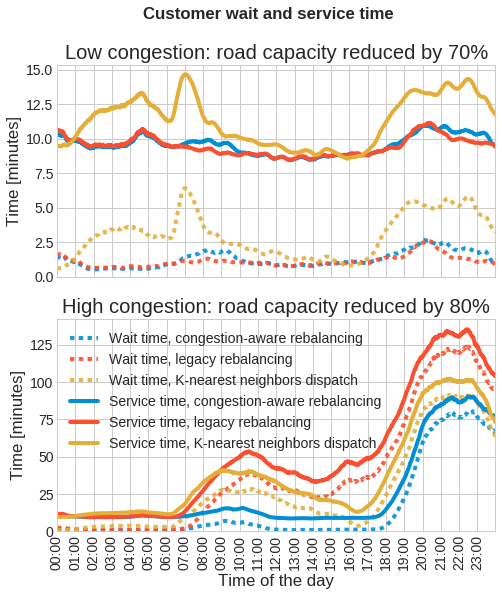

In [31]:
plt.style.use(['fivethirtyeight','seaborn-white','seaborn-whitegrid'])
import matplotlib.dates as mdates

fig=plt.figure(figsize=(7,4))
#st=fig.suptitle("Customer wait and service time",fontsize='large',fontweight='bold')

ax =plt.subplot(111)
hfmt = mdates.DateFormatter('%H:00')
ax.plot(times_C_25,SlidingServTime_C_25/60.,color='C0',label='Congestion-aware rebalancing, service time')
ax.plot(times_L_25,SlidingServTime_L_25/60.,color='C1',label='Baseline rebalancing, service time')
ax.plot(times_N_25,SlidingServTime_N_25/60.,color='C2',label='Nearest neighbors dispatch, service time')
ax.plot(times_C_25,SlidingWaitTime_C_25/60.,color='C0',linestyle='dotted',alpha=0.9,label='Congestion-aware rebalancing, wait time')
ax.plot(times_L_25,SlidingWaitTime_L_25/60.,color='C1',linestyle='dotted',alpha=0.9,label='Baseline rebalancing, wait time')
ax.plot(times_N_25,SlidingWaitTime_N_25/60.,color='C2',linestyle='dotted',alpha=0.9,label='Nearest neighbors dispatch, wait time')
#ax2.xaxis.set_major_locator(mdates.HourLocator())
#ax2.xaxis.set_major_formatter(hfmt)
ax.set_xlim(min(times_C_25),max(times_C_25))
ax.set_ylim(bottom = 0)

plt.setp(ax2.get_xticklabels(),visible=False)
#ax2.set_xlabel('Time of the day')
ax.set_ylabel('Time [minutes]')
ax.set_title('Medium congestion: road capacity reduced by 75%')
plt.xticks(rotation='vertical')
mylegend=ax.legend(loc=0,shadow=True)
mylegend.get_frame().set_facecolor('w')
#ax2.set_axis_bgcolor('w')


ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(hfmt)
ax.set_xlim(min(times_C_20),max(times_C_20))
ax.set_ylim(bottom = 0)
ax.set_xlabel('Time of the day')
ax.set_ylabel('Time [minutes]')
plt.xticks(rotation='vertical')

fig.patch.set_facecolor([1, 1, 1, 1])
#plt.show()
plt.savefig('MATSIM_result_plot_predefense_medium.pdf',bbox_inches='tight',facecolor='w')

### HIGH CONGESTION

plt.style.use(['fivethirtyeight','seaborn-white','seaborn-whitegrid'])
import matplotlib.dates as mdates

fig=plt.figure(figsize=(7,4))
#st=fig.suptitle("Customer wait and service time",fontsize='large',fontweight='bold')

ax =plt.subplot(111)
hfmt = mdates.DateFormatter('%H:00')
ax.plot(times_C_25,SlidingServTime_C_20/60.,color='C0',label='Congestion-aware rebalancing, service time')
ax.plot(times_L_25,SlidingServTime_L_20/60.,color='C1',label='Baseline rebalancing, service time')
ax.plot(times_N_25,SlidingServTime_N_20/60.,color='C2',label='Nearest neighbors dispatch, service time')
ax.plot(times_C_25,SlidingWaitTime_C_20/60.,color='C0',linestyle='dotted',alpha=0.9,label='Congestion-aware rebalancing, wait time')
ax.plot(times_L_25,SlidingWaitTime_L_20/60.,color='C1',linestyle='dotted',alpha=0.9,label='Baseline rebalancing, wait time')
ax.plot(times_N_25,SlidingWaitTime_N_20/60.,color='C2',linestyle='dotted',alpha=0.9,label='Nearest neighbors dispatch, wait time')
#ax2.xaxis.set_major_locator(mdates.HourLocator())
#ax2.xaxis.set_major_formatter(hfmt)
ax.set_xlim(min(times_C_20),max(times_C_20))
ax.set_ylim(bottom = 0)

plt.setp(ax2.get_xticklabels(),visible=False)
#ax2.set_xlabel('Time of the day')
ax.set_ylabel('Time [minutes]')
ax.set_title('High congestion: road capacity reduced by 80%')
plt.xticks(rotation='vertical')
mylegend=ax.legend(loc=0,shadow=True)
mylegend.get_frame().set_facecolor('w')
#ax2.set_axis_bgcolor('w')


ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(hfmt)
ax.set_xlim(min(times_C_20),max(times_C_20))
ax.set_ylim(bottom = 0)
ax.set_xlabel('Time of the day')
ax.set_ylabel('Time [minutes]')
plt.xticks(rotation='vertical')

fig.patch.set_facecolor([1, 1, 1, 1])
#plt.show()
plt.savefig('MATSIM_result_plot_predefense_high.pdf',bbox_inches='tight',facecolor='w')

### LOW CONGESTION

plt.style.use(['fivethirtyeight','seaborn-white','seaborn-whitegrid'])
import matplotlib.dates as mdates

fig=plt.figure(figsize=(7,4))
#st=fig.suptitle("Customer wait and service time",fontsize='large',fontweight='bold')

ax =plt.subplot(111)
hfmt = mdates.DateFormatter('%H:00')
ax.plot(times_C_25,SlidingServTime_C_30/60.,color='C0',label='Congestion-aware rebalancing, service time')
ax.plot(times_L_25,SlidingServTime_L_30/60.,color='C1',label='Baseline rebalancing, service time')
ax.plot(times_N_25,SlidingServTime_N_30/60.,color='C2',label='Nearest neighbors dispatch, service time')
ax.plot(times_C_25,SlidingWaitTime_C_30/60.,color='C0',linestyle='dotted',alpha=0.9,label='Congestion-aware rebalancing, wait time')
ax.plot(times_L_25,SlidingWaitTime_L_30/60.,color='C1',linestyle='dotted',alpha=0.9,label='Baseline rebalancing, wait time')
ax.plot(times_N_25,SlidingWaitTime_N_30/60.,color='C2',linestyle='dotted',alpha=0.9,label='Nearest neighbors dispatch, wait time')
#ax2.xaxis.set_major_locator(mdates.HourLocator())
#ax2.xaxis.set_major_formatter(hfmt)
ax.set_xlim(min(times_C_30),max(times_C_30))
ax.set_ylim(bottom = 0)

plt.setp(ax2.get_xticklabels(),visible=False)
#ax2.set_xlabel('Time of the day')
ax.set_ylabel('Time [minutes]')
ax.set_title('Low congestion: road capacity reduced by 70%')
plt.xticks(rotation='vertical')
mylegend=ax.legend(loc=0,shadow=True)
mylegend.get_frame().set_facecolor('w')
#ax2.set_axis_bgcolor('w')


ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(hfmt)
ax.set_xlim(min(times_C_30),max(times_C_30))
ax.set_ylim(bottom = 0)
ax.set_xlabel('Time of the day')
ax.set_ylabel('Time [minutes]')
plt.xticks(rotation='vertical')

fig.patch.set_facecolor([1, 1, 1, 1])
#plt.show()
plt.savefig('MATSIM_result_plot_predefense_low.pdf',bbox_inches='tight',facecolor='w')


#### HIGH and LOW

print(plt.style.available)
plt.style.use(['fivethirtyeight','seaborn-white','seaborn-whitegrid'])
import matplotlib.dates as mdates

fig=plt.figure(figsize=(7,8))
st=fig.suptitle("Customer wait and service time",fontsize='large',fontweight='bold')
ax1 =plt.subplot(211)
hfmt = mdates.DateFormatter('%H:00')
ax1.plot(times_C_30,SlidingWaitTime_C_30/60.,color='C0',linestyle='dotted',alpha=0.9,label='Wait time, congestion-aware rebalancing')
ax1.plot(times_L_30,SlidingWaitTime_L_30/60.,color='C1',linestyle='dotted',alpha=0.9,label='Wait time, legacy rebalancing')
ax1.plot(times_N_30,SlidingWaitTime_N_30/60.,color='C2',linestyle='dotted',alpha=0.9,label='Wait time, K-nearest neighbors dispatch')
ax1.plot(times_C_30,SlidingServTime_C_30/60.,color='C0',label='Service time, congestion-aware rebalancing')
ax1.plot(times_L_30,SlidingServTime_L_30/60.,color='C1',label='Service time, legacy rebalancing')
ax1.plot(times_N_30,SlidingServTime_N_30/60.,color='C2',label='Service time, K-nearest neighbors dispatch')
#ax1.xaxis.set_major_locator(mdates.HourLocator())
#ax1.xaxis.set_major_formatter(hfmt)
plt.setp(ax1.get_xticklabels(),visible=False)
ax1.set_xlim(min(times_C_30),max(times_C_30))
ax1.set_ylim(bottom = 0)
#ax1.set_xlabel('Time of the day')
ax1.set_ylabel('Time [minutes]')
ax1.set_title('Low congestion: road capacity reduced by 70%')
plt.xticks(rotation='vertical')
#ax1.legend()

# ax2 =plt.subplot(312,sharex=ax1)
# hfmt = mdates.DateFormatter('%H:00')
# ax2.plot(times_C_25,SlidingServTime_C_25/60.,color='C0',label='Congestion-aware rebalancing, service time')
# ax2.plot(times_L_25,SlidingServTime_L_25/60.,color='C1',label='Baseline rebalancing, service time')
# ax2.plot(times_N_25,SlidingServTime_N_25/60.,color='C2',label='Nearest neighbors dispatch, service time')
# ax2.plot(times_C_25,SlidingWaitTime_C_25/60.,color='C0',linestyle='dotted',alpha=0.9,label='Congestion-aware rebalancing, wait time')
# ax2.plot(times_L_25,SlidingWaitTime_L_25/60.,color='C1',linestyle='dotted',alpha=0.9,label='Baseline rebalancing, wait time')
# ax2.plot(times_N_25,SlidingWaitTime_N_25/60.,color='C2',linestyle='dotted',alpha=0.9,label='Nearest neighbors dispatch, wait time')
# #ax2.xaxis.set_major_locator(mdates.HourLocator())
# #ax2.xaxis.set_major_formatter(hfmt)
# ax2.set_xlim(min(times_C_25),max(times_C_25))
# ax2.set_ylim(bottom = 0)

# plt.setp(ax2.get_xticklabels(),visible=False)
# #ax2.set_xlabel('Time of the day')
# ax2.set_ylabel('Time [minutes]')
# ax2.set_title('Medium congestion: road capacity reduced by 75%')
# plt.xticks(rotation='vertical')
# mylegend=ax2.legend(loc=0,shadow=True)
# mylegend.get_frame().set_facecolor('w')
# #ax2.set_axis_bgcolor('w')

ax3 =plt.subplot(212,sharex=ax1)
hfmt = mdates.DateFormatter('%H:00')
ax3.plot(times_C_20,SlidingWaitTime_C_20/60.,color='C0',linestyle='dotted',alpha=0.9,label='Wait time, congestion-aware rebalancing')
ax3.plot(times_L_20,SlidingWaitTime_L_20/60.,color='C1',linestyle='dotted',alpha=0.9,label='Wait time, legacy rebalancing')
ax3.plot(times_N_20,SlidingWaitTime_N_20/60.,color='C2',linestyle='dotted',alpha=0.9,label='Wait time, K-nearest neighbors dispatch')
ax3.plot(times_C_20,SlidingServTime_C_20/60.,color='C0',label='Service time, congestion-aware rebalancing')
ax3.plot(times_L_20,SlidingServTime_L_20/60.,color='C1',label='Service time, legacy rebalancing')
ax3.plot(times_N_20,SlidingServTime_N_20/60.,color='C2',label='Service time, K-nearest neighbors dispatch')
ax3.xaxis.set_major_locator(mdates.HourLocator())
ax3.xaxis.set_major_formatter(hfmt)
ax3.set_xlim(min(times_C_20),max(times_C_20))
ax3.set_ylim(bottom = 0)
ax3.set_xlabel('Time of the day')
ax3.set_ylabel('Time [minutes]')
ax3.set_title('High congestion: road capacity reduced by 80%')
plt.xticks(rotation='vertical')
mylegend=ax3.legend(loc=0,shadow=True)
mylegend.get_frame().set_facecolor('w')

fig.patch.set_facecolor([1, 1, 1, 1])
#plt.show()
plt.savefig('MATSIM_result_plot_predefense_hilo.pdf',bbox_inches='tight',facecolor='w')

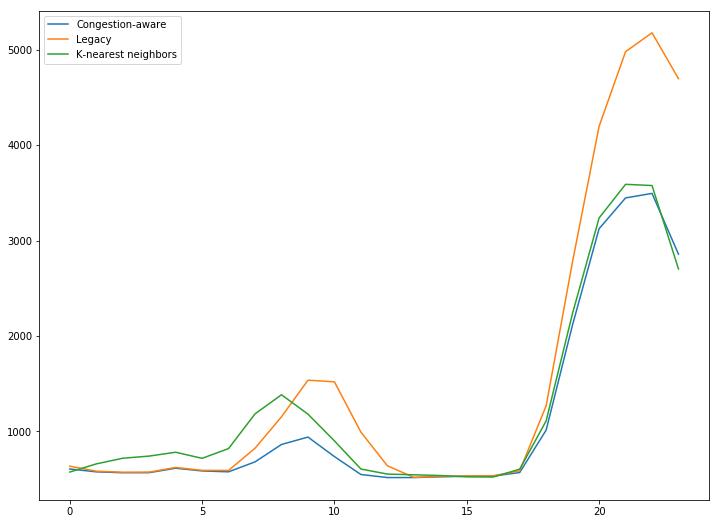

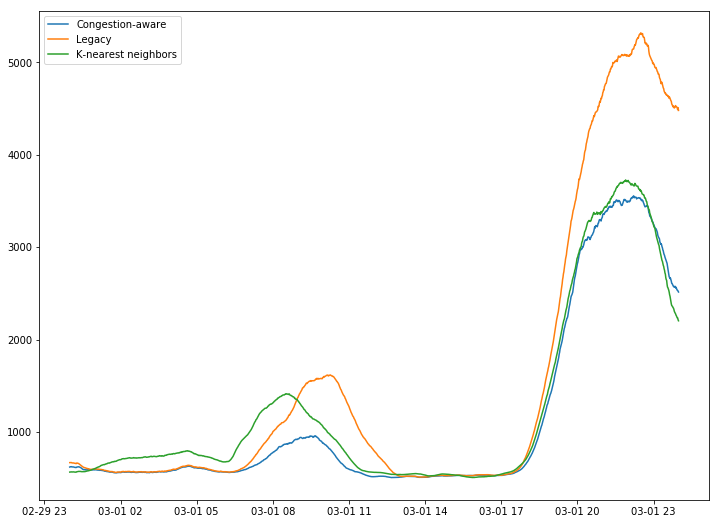

In [155]:
plt.figure()
plt.plot(MeanServiceTime_C,label='Congestion-aware')
plt.plot(MeanServiceTime_L,label='Legacy')
plt.plot(MeanServiceTime_N,label='K-nearest neighbors')
plt.legend()


plt.figure()
plt.plot(times_C,SlidingServTime_C,label='Congestion-aware')
plt.plot(times_L,SlidingServTime_L,label='Legacy')
plt.plot(times_N,SlidingServTime_N,label='K-nearest neighbors')
plt.legend()

In [13]:
VehiclesPerHr_C_25, RelUtilPerHr_C_25 = get_traffic_data(eventsfile_C,LinkIDMap)
VehiclesPerHr_L_25, RelUtilPerHr_L_25 = get_traffic_data(eventsfile_L,LinkIDMap)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [34]:
def plot_traffic_difference_absolute(G,VehPerHr1,VehPerHr2,LinkIDMap,hours,_cmap=plt.cm.RdYlGn):
    import networkx as nx
    import matplotlib.pyplot as plt
    import sqlite3
    
    myedgelist=[]
    for i in range(len(LinkIDMap.keys())):
        myedgelist.append(LinkIDMap[i+1])
    nodepos={}
    for nodeix, node in G.node.iteritems():
        nodepos[nodeix]=[node['x'],node['y']]
    
    VehDiff=VehPerHr1-VehPerHr2
    VehDiffRel=VehDiff/VehPerHr2
    
    for h in hours:
        myfig=plt.figure()
        myax=plt.subplot(121)
        traffic=nx.draw_networkx_edges(G,nodepos,edgelist=myedgelist,edge_color=VehDiffRel[...,h],edge_cmap=_cmap,node_size=0,arrows=False,ax=myax)
        fig_size=[12,9]
        #fig_size[0] = 12
        #fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size
        #nx.draw(G,nodepos,node_size=1)
        traffic.set_clim(-1,1)
        cbarr=plt.colorbar(traffic)
        cbarr.ax.tick_params('labelsize=24')
        plt.axis('equal')
        plt.title(str(h)+' to '+str(h+1))
        
    return myfig, myax, cbarr

def plot_traffic_difference_relative(G,RelUtilPerHr1,RelUtilPerHr2,LinkIDMap,hours):
    import networkx as nx
    import matplotlib.pyplot as plt
    import sqlite3
    
    myedgelist=[]
    for i in range(len(LinkIDMap.keys())):
        myedgelist.append(LinkIDMap[i+1])
    nodepos={}
    for nodeix, node in G.node.iteritems():
        nodepos[nodeix]=[node['x'],node['y']]
    
    RelUtilDiff=RelUtilPerHr1-RelUtilPerHr2
    
    for h in hours:
        plt.figure()
        myax=plt.subplot(121)
        traffic=nx.draw_networkx_edges(G,nodepos,edgelist=myedgelist,edge_color=RelUtilDiff[...,h],edge_cmap=plt.cm.RdYlGn,node_size=0,arrows=False,vmin=0,vmax=1)
        fig_size=[12,9]
        #fig_size[0] = 12
        #fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size
        #nx.draw(G,nodepos,node_size=1)
        #traffic.set_clim(-1,1)
        plt.colorbar(traffic)
        plt.axis('equal')
        plt.title(str(h)+' to '+str(h+1))
    return myax

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide


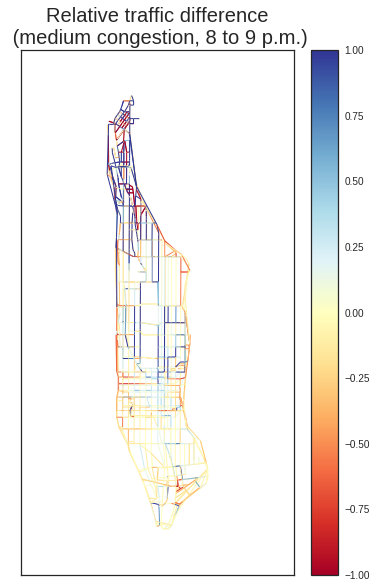

In [37]:
#plot_traffic_data(G,RelUtilPerHr_C_25,LinkIDMap,[20])
#plot_traffic_data(G,RelUtilPerHr_L_25,LinkIDMap,[20])
#Use colormap RdYlGn\
import matplotlib.pyplot as plt

plt.style.use(['fivethirtyeight','seaborn-white'])

myfig, myax, cbarr = plot_traffic_difference_absolute(G,VehiclesPerHr_L_25,VehiclesPerHr_C_25,LinkIDMap,[20],plt.cm.RdYlBu)

myax.get_xaxis().set_visible(False)
myax.get_yaxis().set_visible(False)

myax.set_title('Relative traffic difference\n (medium congestion, 8 to 9 p.m.)')
plt.savefig('CongComparison_plot.pdf',bbox_inches='tight',facecolor='w')

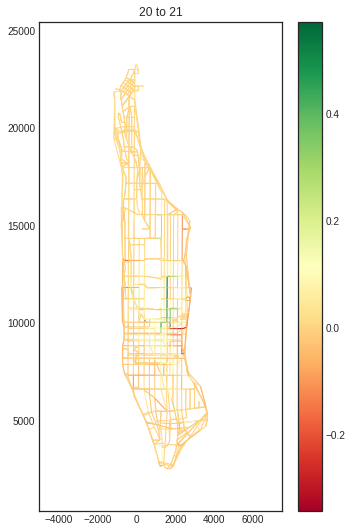

In [25]:
plot_traffic_difference_relative(G,RelUtilPerHr_L_25,RelUtilPerHr_C_25,LinkIDMap,[20])

In [504]:
print len(G.nodes()), len(G.edges())

1351 3137


In [10]:
plansfile = '/home/frossi2/SVN/code/AMoD_congestion/AMoD_taxi/src/main/resources/plans/march05plansOSM_24h.xml'
PlansNet=ET.parse(plansfile)
proot=PlansNet.getroot()
deptime_zero=dt.strptime('00:00:00','%H:%M:%S')

pnum=0
pids=[]
pstarts=[]
paxdata={}
for person in proot:
    pid=person.get('id')
    pids.append(int(pid))
    plan=person.getchildren()[0]
    #print plan.getchildren()
    leg=plan.find('leg')
    #print leg.attrib
    deptime=leg.get('dep_time')
    #print deptime, type(deptime)
    deptime_dt=dt.strptime(deptime,'%H:%M:%S')
    deptime_seconds=(deptime_dt-deptime_zero).total_seconds() 
    pstarts.append(deptime_seconds)
    pnum+=1
    paxdata[int(pid)]=[deptime_seconds, 0., 0.]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


In [12]:
len(paxdata)

481989

In [13]:
max(paxdata.keys())

482834